In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from tensorflow.keras.models import load_model
from PIL import Image 

C:\Users\NW\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_subclasses\functional_tensor.py:295: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


ModuleNotFoundError: No module named 'torchvision'

In [2]:
# Configuración básica
train_dir = 'C:/EPN/2024-B/IA/Proyecto/Datos/procesados2/train_balanced'
val_dir = 'C:/EPN/2024-B/IA/Proyecto/Datos/procesados2/val_balanced'
batch_size = 32
num_classes = 3  # Tonalidad blanca, tonalidad media, tonalidad oscura
learning_rate = 0.001
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Transformaciones para preprocesar las imágenes
data_transforms = {
    'train': transforms.Compose([
        # Redimensiona las imágenes a 224x224 píxeles
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        # Transforma las imágenes a tensores de PyTorch
        transforms.ToTensor(),
        # Normalización de las imágenes con la media y desviación estándar de ImageNet.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Cargar los datos
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
len(train_dataset)
len(val_dataset)

2547

In [ ]:
# Modelo preentrenado
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Reemplazar la capa final para 3 clases
model = model.to(device)

c:\Users\qkevi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\qkevi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

NameError: name 'model' is not defined

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
  

    for epoch in range(num_epochs):
        all_labels = []
        all_preds = []
        # Entrenamiento
        model.train()
        running_loss = 0.0
        running_corrects = 0
        processed_images = 0

        # Barra de progreso para entrenamiento
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_images += inputs.size(0)

            # Actualizar la barra de progreso con la pérdida promedio
            progress_bar.set_postfix({'loss': running_loss / processed_images})

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        # Validación al final de cada época
        model.eval()
        val_loss = 0.0
        val_corrects = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())

        # Imprimir métricas al final de la época
        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Devolver historial y métricas finales
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history, all_labels, all_preds

In [8]:
# Entrenar el modelo
trained_model, train_loss_history, train_acc_history, val_loss_history, val_acc_history, all_labels, all_preds = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)


Epoch 1/10 -> Train Loss: 0.1951, Train Acc: 0.9315, Val Loss: 0.0882, Val Acc: 0.9678


Epoch 2/10 -> Train Loss: 0.1306, Train Acc: 0.9533, Val Loss: 0.1025, Val Acc: 0.9658


Epoch 3/10 -> Train Loss: 0.1435, Train Acc: 0.9495, Val Loss: 0.0845, Val Acc: 0.9682


Epoch 4/10 -> Train Loss: 0.1129, Train Acc: 0.9583, Val Loss: 0.0903, Val Acc: 0.9698


Epoch 5/10 -> Train Loss: 0.1055, Train Acc: 0.9605, Val Loss: 0.0755, Val Acc: 0.9761


Epoch 6/10 -> Train Loss: 0.1089, Train Acc: 0.9594, Val Loss: 0.0735, Val Acc: 0.9749


Epoch 7/10 -> Train Loss: 0.1095, Train Acc: 0.9588, Val Loss: 0.0794, Val Acc: 0.9702


Epoch 8/10 -> Train Loss: 0.1014, Train Acc: 0.9615, Val Loss: 0.0849, Val Acc: 0.9698


Epoch 9/10 -> Train Loss: 0.0974, Train Acc: 0.9628, Val Loss: 0.1174, Val Acc: 0.9564


Epoch 10/10 -> Train Loss: 0.0918, Train Acc: 0.9634, Val Loss: 0.0811, Val Acc: 0.9682


In [9]:
# Presentar métricas finales
print("Training Complete")
print(f'Final Train Loss: {train_loss_history[-1]:.4f} Acc: {train_acc_history[-1]:.4f}')
print(f'Final Val Loss: {val_loss_history[-1]:.4f} Acc: {val_acc_history[-1]:.4f}')

Training Complete
Final Train Loss: 0.0918 Acc: 0.9634
Final Val Loss: 0.0811 Acc: 0.9682


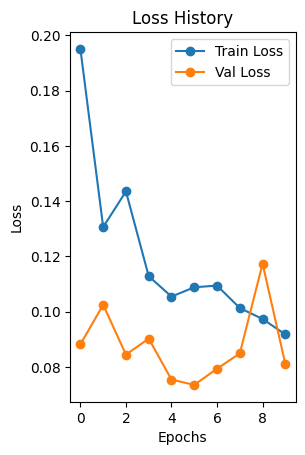

In [10]:
# Subgráfico para la pérdida
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss', marker='o')
plt.plot(val_loss_history, label='Val Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()


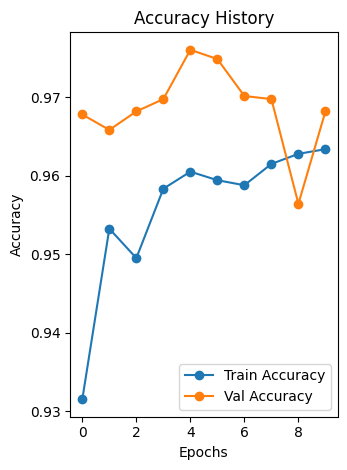

In [11]:
# Subgráfico para la precisión
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy', marker='o')
plt.plot(val_acc_history, label='Val Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy History')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Reporte de clasificación
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

Classification Report:
              precision    recall  f1-score   support

      I & II       0.97      0.94      0.96      8470
    III & IV       0.94      0.97      0.96      8500
      V & VI       1.00      0.99      0.99      8500

    accuracy                           0.97     25470
   macro avg       0.97      0.97      0.97     25470
weighted avg       0.97      0.97      0.97     25470



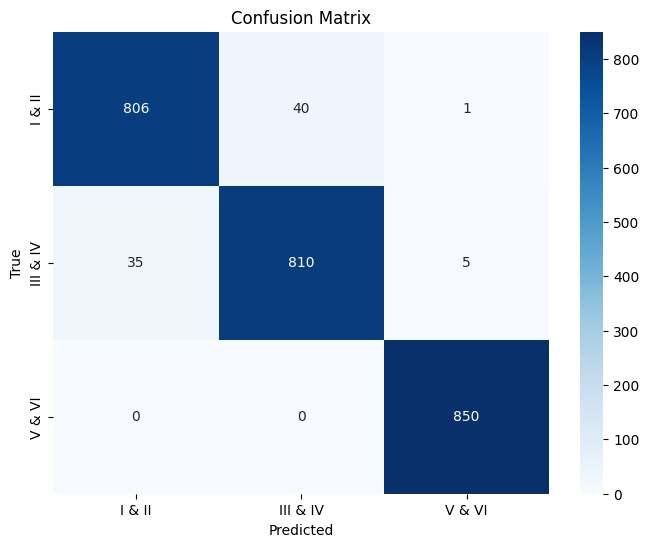

In [33]:
# Matriz de confusión
# Número total de imágenes en el conjunto de validación
num_val_images = len(val_loader.dataset)

# Extraer los últimos datos correspondientes a la última validación
last_labels = all_labels[-num_val_images:]
last_preds = all_preds[-num_val_images:]

cm = confusion_matrix(last_labels, last_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Guardar el modelo 

In [17]:
# Guardar el modelo completo (arquitectura + pesos)
torch.save(model, 'C:/EPN/2024-B/IA/Proyecto/Modelos/model_resnet18.pth')
print("Modelo completo guardado correctamente.")

Modelo completo guardado correctamente.


In [4]:
def predecir_imagen(modelo, ruta_imagen, clases):
    """
    Realiza una predicción sobre una imagen dada utilizando un modelo entrenado.
    
    Args:
        modelo: El modelo de PyTorch cargado y listo para evaluar.
        ruta_imagen: La ruta a la imagen que se desea predecir.
        clases: Lista o diccionario que asocia índices con nombres de clases.
    
    Returns:
        str: La clase predicha para la imagen.
    """
    # 1. Definir las transformaciones necesarias
    transformaciones = transforms.Compose([
        transforms.Resize((224, 224)),            # Redimensionar la imagen a 224x224
        transforms.ToTensor(),                    # Convertir la imagen a un tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalización según ImageNet
                             std=[0.229, 0.224, 0.225])
    ])
    
    # 2. Cargar y preprocesar la imagen
    try:
        imagen = Image.open(ruta_imagen).convert('RGB')  # Asegurar que es RGB
    except Exception as e:
        raise ValueError(f"Error al abrir la imagen: {e}")
    
    imagen_tensor = transformaciones(imagen).unsqueeze(0)  # Agregar dimensión de batch
    
    # 3. Evaluar el modelo
    modelo.eval()  # Asegurarse de que el modelo esté en modo evaluación
    with torch.no_grad():  # No se necesita calcular gradientes
        salida = modelo(imagen_tensor)  # Pasar la imagen procesada al modelo
        _, indice_predicho = torch.max(salida, 1)  # Obtener índice de la clase predicha
    
    # 4. Devolver la clase predicha
    return clases[indice_predicho.item()]

In [3]:
modelo_cargado = torch.load('C:/EPN/2024-B/IA/Proyecto/Modelos/model_resnet18.pth')
# Cambiar a modo evaluación si deseas usarlo para predicciones
print("Modelo completo cargado correctamente.")

Modelo completo cargado correctamente.


C:\Users\qkevi\AppData\Local\Temp\ipykernel_20500\1515668139.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo_cargado = torch.load('C:/EPN/2024-B/IA/Proyecto/Model

In [5]:
clases = {0: 'Tonalidad-blanca', 1: 'Tonalidad-media', 2: 'Tonalidad-oscura'}

In [22]:
ruta_imagen = 'C:/EPN/2024-B/IA/Proyecto/Prediccion/piel10.png'
prediccion = predecir_imagen(modelo_cargado, ruta_imagen, clases)
print(f"La clase predicha es: {prediccion}")

La clase predicha es: Tonalidad-media


### Continuación de entrenamiento del modelo

In [19]:
modelo_cargado = torch.load('C:/EPN/2024-B/IA/Proyecto/Modelos/model_resnet18.pth')

C:\Users\qkevi\AppData\Local\Temp\ipykernel_3452\1046259157.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo_cargado = torch.load('C:/EPN/2024-B/IA/Proyecto/Modelo

In [18]:

def train_model_completly(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    # Almacenar etiquetas y predicciones para classification reports
    all_train_labels_epoch = []  # Etiquetas reales del train por época
    all_train_preds_epoch = []  # Predicciones del train por época
    all_val_labels_epoch = []   # Etiquetas reales del val por época
    all_val_preds_epoch = []    # Predicciones del val por época

    for epoch in range(num_epochs):
        # Variables para acumular métricas del conjunto de entrenamiento
        all_train_labels = []
        all_train_preds = []

        # Entrenamiento
        model.train()
        running_loss = 0.0
        running_corrects = 0
        processed_images = 0

        # Barra de progreso para entrenamiento
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_images += inputs.size(0)

            # Acumular etiquetas reales y predicciones del entrenamiento
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(preds.cpu().numpy())

            # Actualizar la barra de progreso con la pérdida promedio
            progress_bar.set_postfix({'loss': running_loss / processed_images})

        # Calcular métricas del entrenamiento
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())
        all_train_labels_epoch.append(all_train_labels)
        all_train_preds_epoch.append(all_train_preds)

        # Validación al final de cada época
        model.eval()
        val_loss = 0.0
        val_corrects = 0.0

        all_val_labels = []
        all_val_preds = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

                # Acumular etiquetas reales y predicciones del conjunto de validación
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(preds.cpu().numpy())

        # Calcular métricas de validación
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())
        all_val_labels_epoch.append(all_val_labels)
        all_val_preds_epoch.append(all_val_preds)

        # Imprimir métricas al final de la época
        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Devolver todas las métricas y datos para los classification reports
    return (model, train_loss_history, train_acc_history, val_loss_history, val_acc_history, 
            all_train_labels_epoch, all_train_preds_epoch, all_val_labels_epoch, all_val_preds_epoch)


In [24]:
nuevoModelo, train_loss_history, train_acc_history, val_loss_history, val_acc_history, labels_all_train_epoch, labels_preds_train, labels_all_test_epoch, labels_test_preds = train_model_completly(modelo_cargado, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/5 -> Train Loss: 0.1089, Train Acc: 0.9551, Val Loss: 0.0944, Val Acc: 0.9611


Epoch 2/5 -> Train Loss: 0.1072, Train Acc: 0.9547, Val Loss: 0.0944, Val Acc: 0.9627


Epoch 3/5 -> Train Loss: 0.1068, Train Acc: 0.9558, Val Loss: 0.0884, Val Acc: 0.9635


Epoch 4/5 -> Train Loss: 0.1058, Train Acc: 0.9561, Val Loss: 0.0885, Val Acc: 0.9619


Epoch 5/5 -> Train Loss: 0.1058, Train Acc: 0.9553, Val Loss: 0.0983, Val Acc: 0.9611


In [25]:
torch.save(nuevoModelo, 'C:/EPN/2024-B/IA/Proyecto/Modelos/model2_resnet18.pth')
print("Modelo completo guardado correctamente.")

Modelo completo guardado correctamente.
